# HK Low Volatility trading model

For this strategy, we will be backtesting pair trading, a popular statistical abritrage model. In order to do so, we will first normalize the price series. Next, at the start of every month, we will screen out stocks that have deviated and came back to the mean at least 4 times in the previous year, before screening them based on their euclidean distance to select the top 20 stocks. In the following one month, if the ratio between these two stocks deviates from the mean by more than 2 standard deviations, we will short/long the ratio accordingly.   

Before we begin, we will define some helper functions to help us to download and process the data from yahoo finance.

## Downloading and processing the data

In [25]:
# We hate warnings
import warnings
warnings.simplefilter('ignore')

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import seaborn as sns
import math
from dateutil.relativedelta import relativedelta
import datetime

In [26]:
def get_yahoo_data(names, tickers, start, end):
    # Pass in a list of stock tickers together with a list of user defined stock names
    # the function will fetch the daily OHLC data of that stock ticker from yahoo and 
    # return it in a dictionary with the name as the key, and the daily stock data 
    # in a dataframe as the value.
    
    # Override existing pandas yahoo api
    yf.pdr_override()
    
    # Create an empty dictionary
    d = {}
    
    # Reindex our columns
    cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
    
    # Iterate through the names and tickers
    for name, ticker in zip(names, tickers):
        df = pdr.get_data_yahoo(ticker, start=start, 
                                  end=end)
        df = df.reindex(columns=cols)
        d[name] = df
    
    return d

In [27]:
def standardize_index(raw_dict, start, end, method='ffill'):
    # Pass in a dictionary, with the keys as the stock names and values
    # as the stock daily data. This function will create a master index from the
    # start date till the end date with the list of all business days, and standardize 
    # the datetime index for all the other stocks. Moreover, by default, this function will apply forward fill
    # for all the missing values in the dataframe after the start date of that particular
    # stock data.
    
    # Create a new dictionary
    d = {}
    
    # Create a master index 
    master_index = pd.date_range(start, end, freq='B')
    
    for key in raw_dict.keys():
        # Get the starting day index of the stock (i.e. the day it started trading)
        start_date_index = raw_dict[key].index[0]
        
        # Standardize the index
        d[key] = raw_dict[key].reindex(master_index)
        d[key].sort_index(inplace=True)
            
        # Seperate the dataframe into two seperate dataframe, before start date and after
        # start date. For the dates after the start date, if there are NaN values, we will 
        # be using the method specified to fill in the values
        before = d[key].loc[:start_date_index]
        after = d[key].loc[start_date_index + BDay(1):]
        after.fillna(method=method, inplace=True)
        # Concatenate the matrices and assign them accordingly
        d[key] = pd.concat([before, after]).copy()
    
    return d

In [28]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [29]:
# Create a list of stocks and their respective tickers

index_names = ['CKH HOLDINGS', 'CLP HOLDINGS', 'HK & CHINA GAS', 'PCCW', 
               'HANG SENG BANK', 'HENDERSON LAND', 'HYSAN DEV', 'SHK PPT', 
               'SWIRE PACIFIC A', 'BANK OF E ASIA', 'MTR CORPORATION', 
               'SWIRE PACIFIC B', 'CITIC', 'SMARTONE TELE', 'CAFE DE CORAL H',
               'VITASOY INTL', 'YUEXIU REIT', 'CONCH VENTURE', 'KERRY LOG NET', 
               'CHINA TELECOM',  'FORTUNE REIT', 'LINK REIT', 
               'CCB', 'CHINA MOBILE', 'CITIC BANK', 'CKI HOLDINGS', 'CK ASSET', 
               'ABC', 'AIA', 'CHINA RE', 'GF SEC', 'SWIREPROPERTIES', 
               'MINSHENG BANK', 'DAHSING BANKING', 'BOC AVIATION', 'BANKCOMM', 
               'BANK OF CHINA', 'CMSC', 'CEB BANK']

index_tickers =['0001.HK', '0002.HK', '0003.HK', '0008.HK', '0011.HK', '0012.HK',
                '0014.HK', '0016.HK', '0019.HK', '0023.HK', '0066.HK', '0087.HK', 
                '0267.HK', '0315.HK', '0341.HK', '0345.HK', '0405.HK', '0586.HK', 
                '0636.HK', '0728.HK', '0778.HK', '0823.HK', '0939.HK', 
                '0941.HK', '0998.HK', '1038.HK', '1113.HK', '1288.HK', '1299.HK', 
                '1508.HK', '1776.HK', '1972.HK', '1988.HK', '2356.HK', '2588.HK', 
                '3328.HK', '3988.HK', '6099.HK', '6818.HK']

# Set the start date and the end date for our data
start = '2008-01-01'
end = datetime.date.today()

names =  index_names
tickers = index_tickers

# Time to use our helper functions
reits_raw = get_yahoo_data(names=names, tickers=tickers, start=start, end=end)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

In [30]:
# Standardize the index
reits_standardized = standardize_index(reits_raw, start=start, end=end)

In [31]:
# Create a training set for reits
train_df = pd.DataFrame()

for n in names:
    reits_standardized[n]['Signal'] = 0
    reits_standardized[n]['Z_Cross'] = 0
    train_df[n] = reits_standardized[n]['Adj Close']['2016-12-01':'2017-11-30'].dropna()

In [32]:
# Create our test set for reits
test_df = pd.DataFrame()
 
for n in names:
    test_df[n] = reits_standardized[n]['Adj Close']['2016-12-31':'2017-12-31'].dropna()

## Spread-mean crossing

Now, the euclidian distance strategy has shown to be useful in the past, but its profitability has been declining in recent years. There has been a new paper that we are interested in, using spread-mean crossing as a primary criteria (typically at least 4 crossing), then using the euclidian distance as a secondary criteria. Moreover, this strategy emphasizes on selecting quality stocks with low volatility, or selecting stocks within the same industry group (e.g. utilities). 

For our preliminary analysis, we will be focusing on the SG reits + STI index.

### Mean-spread crossing

First and foremost, the most difficult task I am facing is how to write a function that calculates the number of mean-spread crossing over the lookback period. Let's try to figure that out first O.o. 

In [33]:
def oor(s):
    above = s.apply(lambda x: x >= s.mean() + 2 * s.std()).astype(int)
    below = s.apply(lambda x: x < s.mean() - 2 * s.std()).astype(int)
    out_of_range = above + below
    
    return out_of_range

In [34]:
def z_crossing(s):
    
    shifted_val = s.shift(1)

    # Panda series containing boolean variables documenting whether the spread was above the mean yesterday
    above_shifted_val = shifted_val.apply(lambda x: x >= s.mean()).astype(int)
    # Panda series containing boolean variables documenting whether the spread is below the mean today
    below_newratio = s.apply(lambda x: x <= s.mean()).astype(int)
    # Panda series containing boolean variables documenting whether there was a crossing of the mean from above
    crossing_from_above = above_shifted_val * below_newratio 

    # Panda series containing boolean variables documenting whether the spread was below the mean yesterday
    below_shifted_val = shifted_val.apply(lambda x: x <= s.mean()).astype(int)
    # Panda series containing boolean variables documenting whether the spread is above the mean today
    above_newratio = s.apply(lambda x: x >= s.mean()).astype(int)
    # Panda series containing boolean variables documenting whether there was a crossing of the mean from above
    crossing_from_below = below_shifted_val * above_newratio 

    # Sum up the crossing from above and crossing from below
    zero_crossing = crossing_from_above + crossing_from_below
    
    return zero_crossing

In [35]:
def number_of_crossings(s):
    
    out_of_range = oor(s)
    zero_crossing = z_crossing(s)
    
    # Combine the out of range series and zero crossing series into a single pandas dataframe
    new_df = pd.DataFrame()
    new_df['oor'] = out_of_range
    new_df['zero_crossing'] = zero_crossing

    active = 0
    count = 0

    for index, row in new_df.iterrows():
    
        # If the stock is not outside the prescribed range, continue the loop
        if active == 0:
            active = row['oor']
    
        # Else, if the stock is outside the prescribed range, record a crossing once a zero crossing 
        # takes place
        elif active == 1:
            if row['zero_crossing'] == 1:
                count += 1
                active = 0
                
    return count

In [36]:
def pairs_with_min_m_crossings(m, data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[data.columns[i]]
            S2 = data[data.columns[j]]
            norm_S1 = S1/S1[0:5].median()
            norm_S2 = S2/S2[0:5].median()
            newratio = norm_S1/norm_S2
            score = number_of_crossings(newratio)
            score_matrix[i, j] = score
            if score > m:
                pairs.append((keys[i], keys[j]))
    
    return score_matrix, pairs

## Lowest distance

Now we will be writing a function to select the top m pairs who have had the closest distance between their normalized prices over our lookback period.

In [37]:
def lowest_n_distance_pairs(m, data, pairs):
    n = len(pairs)
    score_matrix = np.zeros((n))
    for i in range(n):
        p = pairs[i]
        S1 = data[p[0]]
        S2 = data[p[1]]
        norm_S1 = S1/S1[0:5].median()
        norm_S2 = S2/S2[0:5].median()
        score = (((norm_S1 - norm_S2) ** 2) ** (1/2)).sum()
        score_matrix[i] = score
    
    index = score_matrix.argsort()[:m]
    sel_pairs = np.asarray(pairs)[index].tolist()
    return score_matrix, sel_pairs

In [38]:
# Create trade signals for our selected pairs
def create_trade_signal(ratio, S1):
    
    position = 0
    pos_size = 0
    
    signal = pd.Series(index=ratio.index)
    actual_trade = pd.Series(index=ratio.index) 
    ratio['Prices'] = S1
    
    for index, row in ratio.iterrows():        
    # If there are no open positions currently
        if position == 0:
            position = -row[1]
            pos_size = position * (10/row[3])
            signal[index] = position
            actual_trade[index] = position * pos_size
        
        # If there is a position
        else:
            # If a zero crossing took place
            if row[2] == 1:
                if position == row[1]:
                    position = -row[1] 
                    signal[index] = position * 2
                    pos_size = pos_size + (10/row[3])
                    actual_trade[index] = pos_size * position
                    pos_size = 10/row[0]
                
                else:
                    signal[index] = -position
                    actual_trade[index] = -position * pos_size
                    position = 0
                    pos_size = 0
    
    signal.fillna(0, inplace=True)
    actual_trade.fillna(0, inplace=True)
    return signal, actual_trade

In [39]:
# Calculate the gross pnl for each trade with a 0.2% transaction cost embedded
def calculate_PnL(data):
    pl = 0
    gross = ((-data['Adj Close'] * data['Trades']) - 0.002 * abs(-data['Adj Close'] * data['Trades'])).sum()
    
    if data['Trades'].sum() == 0:
        pl = gross 
    
    else:
        pl = gross + (data['Trades'].sum() * data['Adj Close'].tail(1)[0])
    
    return pl

In [40]:
# Calculate the overall pnl for our backtest
def calculate_overall_pnl(data, pairs, start, train_end, end):

    overall_pnl = 0
    
    for pair in pairs:
    
        # Create the old time series because we need the mean and the std
        old_S1 = data[pair[0]]['Adj Close'][start:train_end]
        old_S2 = data[pair[1]]['Adj Close'][start:train_end]
        norm_old_S1 = old_S1/old_S1[0:5].median()
        norm_old_S2 = old_S2/old_S2[0:5].median()
        old_ratio = norm_old_S1/norm_old_S2

        # Create the time series for the period that we are interested in
        S1 = pd.DataFrame(data[pair[0]]['Adj Close'][train_end:end]) 
        S2 = pd.DataFrame(data[pair[1]]['Adj Close'][train_end:end])
        norm_S1 = S1/old_S1[0:5].median() 
        norm_S2 = S2/old_S2[0:5].median()
    
        # Calculate the ratio using the old mean and std
        ratio = pd.DataFrame(((norm_S1/norm_S2) - old_ratio.mean())/(old_ratio.std()))
        ratio['Out_of_range'] = 0
    
        # Define a new series stating whether the ratio is above or below 2 std
        above_range = ratio['Adj Close'].apply(lambda x: x > 2).astype(int)
        below_range = ratio['Adj Close'].apply(lambda x: x < -2).astype(int)
    
        # Modify the positions column accordingly
        ratio['Out_of_range'] = ratio['Out_of_range'].add(above_range)
        ratio['Out_of_range'] = ratio['Out_of_range'].subtract(below_range)
    
        shifted_val = ratio['Adj Close'].shift(1)

        # Panda series containing boolean variables documenting whether the spread was above the mean yesterday
        above_shifted_val = shifted_val.apply(lambda x: x >= 0).astype(int)
        # Panda series containing boolean variables documenting whether the spread is below the mean today
        below_newratio = ratio['Adj Close'].apply(lambda x: x <= 0).astype(int)
        # Panda series containing boolean variables documenting whether there was a crossing of the mean from above
        crossing_from_above = above_shifted_val * below_newratio 

        # Panda series containing boolean variables documenting whether the spread was below the mean yesterday
        below_shifted_val = shifted_val.apply(lambda x: x <= 0).astype(int)
        # Panda series containing boolean variables documenting whether the spread is above the mean today
        above_newratio = ratio['Adj Close'].apply(lambda x: x >= 0).astype(int)
        # Panda series containing boolean variables documenting whether there was a crossing of the mean from above
        crossing_from_below = below_shifted_val * above_newratio 

        # Sum up the crossing from above and crossing from below
        zero_crossing = crossing_from_above + crossing_from_below
        ratio['Z_cross'] = zero_crossing
    
        # Create the trade signals for S1 and S2
        S1_signal, S1_actual_trade = create_trade_signal(ratio, S1)
        S1['Trades'] = S1_actual_trade
    
        S2_signal, S2_actual_trade = create_trade_signal(ratio, S2)
        S2['Trades'] = -S2_actual_trade
    
        # Calculate the final pnl
        pnl = calculate_PnL(S1) + calculate_PnL(S2)
        overall_pnl +=pnl
        
    return overall_pnl

## Start of our backtest

Assumptions:
- No trading cost
- Backtest period from Jan 2009 to Dec 2017
- Select the top 20 pairs and rebalance monthly

In [17]:
# Define the start and the end of our backtest
start_date_range = pd.date_range(start, '2017-12-31', 
                                   freq='BMS', tz='Asia/Singapore')

end_date_range = pd.date_range(start, '2017-12-31',
                               freq='BM', tz='Asia/Singapore')

In [41]:
# Function to backtest our complete strategy
def pair_trading_full_backtest(data, names, start_date_range, end_date_range):
    
    full_pnl = pd.Series()
    full_pairs = pd.Series()
    full_results = pd.DataFrame()
    
    for i in range(len(start_date_range) - 12):
        
        # Define start, train_end and end dates
        start = start_date_range[0+i]
        train_end = end_date_range[11+i]
        end = end_date_range[12+i]
        
        # Create a training set
        new_train_df = pd.DataFrame()
        for n in names:
            new_train_df[n] = data[n]['Adj Close'][start:train_end].dropna()
        
        # First filter pairs with at least 4 crossovers during the formation period
        score, min_crossing = pairs_with_min_m_crossings(3, new_train_df)
        
        # Out of the filtered pairs, select the 20 with the lowest distance
        score_matrix, sel_pairs = lowest_n_distance_pairs(4, new_train_df,
                                                  min_crossing)
        
        # Calculate the month's pnl for the selected pairs
        pnl = calculate_overall_pnl(data, sel_pairs, start, train_end, end)
        
        # Record the month's pnl & selected pairs
        full_pnl[end] = pnl
        full_pairs[end] = sel_pairs
        
    full_results['PNL'] = full_pnl
    full_results['Pairs'] = full_pairs
    
    return full_results

In [71]:
full_results = pair_trading_full_backtest(reits_standardized, names, start_date_range, end_date_range)

## Backtest results

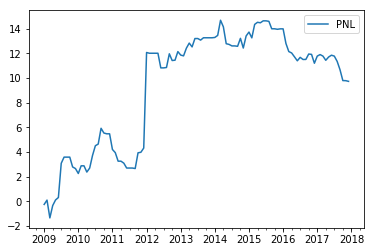

In [72]:
full_results.cumsum().plot()

In [62]:
full_results.to_csv(r'C:\Users\Law Wen Yu\Desktop\Low_Vol.csv')

In [42]:
# Define the start and the end of our backtest
start_date_range = pd.date_range('2017-01-01', '2018-07-31', 
                                   freq='BMS', tz='Asia/Singapore')

end_date_range = pd.date_range('2017-01-01', '2018-07-31',
                               freq='BM', tz='Asia/Singapore')

In [43]:
forward_full_results = pair_trading_full_backtest(reits_standardized, names, start_date_range, end_date_range)

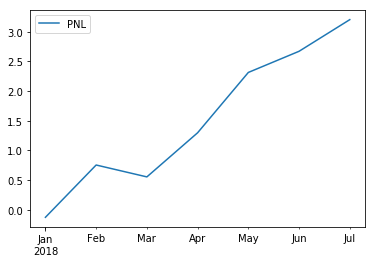

In [44]:
forward_full_results.cumsum().plot()

### Time to put it into practice!

In [18]:
# Get the starting date of this month and the date 1 year prior
new_end = datetime.date.today().replace(day=1)
new_start = new_end - relativedelta(years=1)

# Create a training set
new_train_df = pd.DataFrame()
for n in names:
    new_train_df[n] = reits_standardized[n]['Adj Close'][new_start:new_end].dropna()
        
# First filter pairs with at least 4 crossovers during the formation period
score, min_crossing = pairs_with_min_m_crossings(3, new_train_df)
        
# Out of the filtered pairs, select the 10 with the lowest distance
score_matrix, sel_pairs = lowest_n_distance_pairs(10, new_train_df, min_crossing)

In [19]:
sel_pairs

[['YUEXIU REIT', 'AIA'],
 ['PCCW', 'AIA'],
 ['BANK OF E ASIA', 'CITIC'],
 ['CITIC', 'CHINA RE'],
 ['CITIC', 'DAHSING BANKING']]

### Graph of the normalized spread

In [20]:
# Create a new test set for the forward testing procedure
new_test_df = pd.DataFrame()
for n in names:
    new_test_df[n] = reits_standardized[n]['Adj Close'][new_start:datetime.date.today()].dropna()

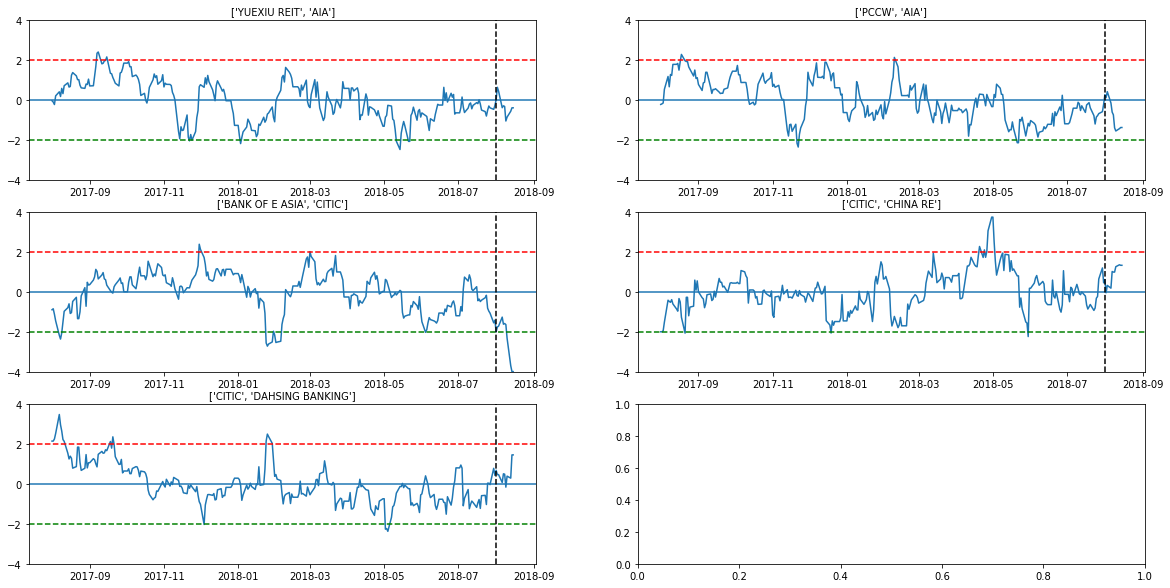

In [21]:
fig, ax = plt.subplots(math.ceil(len(sel_pairs)/2), 2, figsize=(20,10))

for i in range(0, len(sel_pairs)):
    # Using the past 1 year prices, normalize the price series and calculate the ratio 
    old_S1 = new_train_df[sel_pairs[i][0]]
    old_S2 = new_train_df[sel_pairs[i][1]]
    old_S1_norm = old_S1/old_S1[0:5].median()
    old_S2_norm = old_S2/old_S2[0:5].median()
    old_ratio = old_S1_norm/old_S2_norm 

    # Normalize the price series using the old mean
    S1 = new_test_df[sel_pairs[i][0]]/old_S1[0:5].median()
    S2 = new_test_df[sel_pairs[i][1]]/old_S2[0:5].median()
    
    ratio = S1/S2
    ratio_norm = (ratio - old_ratio.mean())/old_ratio.std()
    
    ax[math.floor(i/2),i%2].plot(ratio_norm)
    ax[math.floor(i/2),i%2].set_title(sel_pairs[i], fontsize=10)
    ax[math.floor(i/2),i%2].axhline(0)
    ax[math.floor(i/2),i%2].axhline(2, color='red', linestyle='--')
    ax[math.floor(i/2),i%2].axhline(-2, color='green', linestyle='--')
    ax[math.floor(i/2),i%2].axvline(new_end, color='black', linestyle='--')
    ax[math.floor(i/2),i%2].set_ylim(-4, 4)

### Graph of the two normalized stocks

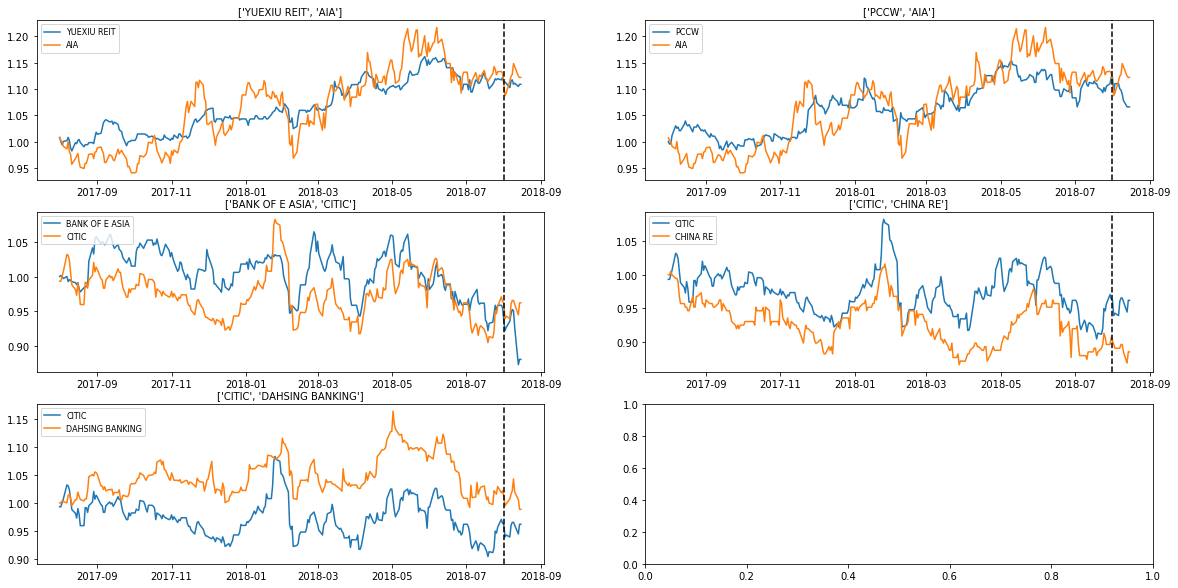

In [22]:
fig, ax = plt.subplots(math.ceil(len(sel_pairs)/2), 2, figsize=(20,10))

for i in range(0, len(sel_pairs)):
    # Using the past 1 year prices, normalize the price series and calculate the ratio 
    old_S1 = new_train_df[sel_pairs[i][0]]
    old_S2 = new_train_df[sel_pairs[i][1]]
    old_S1_norm = old_S1/old_S1[0:5].median()
    old_S2_norm = old_S2/old_S2[0:5].median()
    old_ratio = old_S1_norm/old_S2_norm 

    # Normalize the price series using the old mean
    S1 = new_test_df[sel_pairs[i][0]]/old_S1[0:5].median()
    S2 = new_test_df[sel_pairs[i][1]]/old_S2[0:5].median()
    
    ax[math.floor(i/2),i%2].plot(S1)
    ax[math.floor(i/2),i%2].plot(S2)
    ax[math.floor(i/2),i%2].set_title(sel_pairs[i], fontsize=10)
    ax[math.floor(i/2),i%2].axvline(new_end, color='black', linestyle='--')
    ax[math.floor(i/2),i%2].legend(loc=2, prop={'size': 8}) 

In [27]:
pair = ['BANK OF E ASIA', 'CITIC']
 
old_S1 = new_train_df[pair[0]]
old_S2 = new_train_df[pair[1]]
old_S1_norm = old_S1/old_S1[0:5].median()
old_S2_norm = old_S2/old_S2[0:5].median()
old_ratio = old_S1_norm/old_S2_norm 

# Normalize the price series using the old mean
S1 = new_test_df[pair[0]]/old_S1[0:5].median()
S2 = new_test_df[pair[1]]/old_S2[0:5].median()
    
ratio = S1/S2
ratio_norm = (ratio - old_ratio.mean())/old_ratio.std()